# 12. Cluster Analysis


In [5]:
%run "6.Recommendations_Sample.ipynb"

/var/folders/zt/3tyx89hj6gnf_t8m4vc8mfwm0000gn/T/ipykernel_85605/2749845937.py:9: DtypeWarning: Columns (0,1,2,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(file_path, header=None, skiprows=skiprow)


Number of users 5,000
First five users id [ 9876316 11314799 10333834  8415484  9737805]


/var/folders/zt/3tyx89hj6gnf_t8m4vc8mfwm0000gn/T/ipykernel_85605/3332260560.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)


Number of Rows: 12,663,134
Numbeer of Columns: 37,420
Number of stored values: 47,967,516
Number of Rows: 4,916
Numbeer of Columns: 37,420
Number of stored values: 19,474
Number of Rows: 4,917
Numbeer of Columns: 3,629
Number of stored values: 23,102


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import gzip
import pickle
from scipy.spatial.distance import pdist

def decompress_pickle(input_file):
    with gzip.open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data

user_game_matrix = decompress_pickle('matrix/user_game_matrix.pkl.gz')
user_game_matrix

/var/folders/zt/3tyx89hj6gnf_t8m4vc8mfwm0000gn/T/ipykernel_85605/3332260560.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)


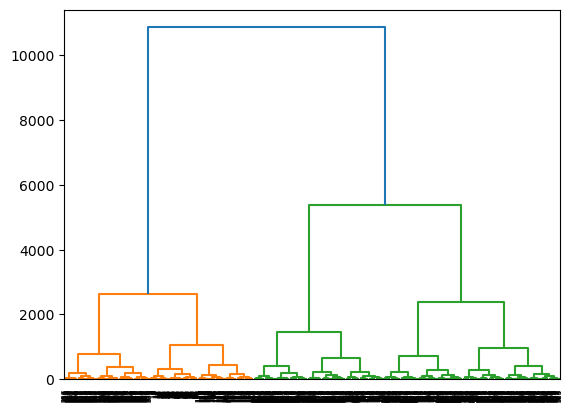

In [7]:
# Load the user-game matrix
user_game_matrix = decompress_pickle('matrix/user_game_matrix.pkl.gz')

# Reduce the size of the user-game matrix
# Replace this with your own filtering logic
filtered_matrix = user_game_matrix[:1000, :1000]

# Convert the sparse matrix to a dense matrix
dense_matrix = filtered_matrix.toarray()

# Compute pairwise distances
pairwise_distances = pdist(dense_matrix)

# Perform hierarchical clustering
# Using the linkage function with the 'ward' method
# Replace 'ward' with your desired linkage method
clusters = linkage(pairwise_distances, method='ward')

# Plot the dendrogram
dendrogram(clusters)

# Show the plot
import matplotlib.pyplot as plt
plt.show()